# Notebook for multiple sessions

In [24]:
import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.model_selection import cross_val_score

In [2]:
from importlib import reload

from wombats import utils
from wombats import metrics
from wombats import models

# if changes to the files run this to reload the moduls
utils = reload(utils)
metrics = reload(metrics)
models = reload(models)

In [3]:
data_file = Path('../data/steinmetz/steinmetz_all.npy')
data_folder = Path('../data/steinmetz/')
if not data_file.exists():
    data = utils.load_steinmentz()
    data_folder.mkdir(parents=True)
    data_file.touch()
    np.save(data_file, data)
else:
    data = np.load(data_file, allow_pickle=True)

In [4]:
n_sessions = len(data)

In [5]:
#@title Representative session
#@markdown Let's see which session has more neurons in the areas that we are going to use and how many neurons it has.

brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                  ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                  ]
regions = ["visual", "motor"]

def count_neurons_per_brain_area():
    neurons_in_session = []
    for i in range (0,n_sessions):
        session = data[i]
        brain_areas = session['brain_area']

        neurons_in_area = []
        for group in brain_groups:
            count = 0
            for area in group:
                count += np.count_nonzero(brain_areas == area)
            neurons_in_area.append(count)
        neurons_in_session.append(neurons_in_area)
    return neurons_in_session

def plot_areas_sessions(sessions, neurons_in_session):
    fig, ax = plt.subplots(figsize=(18, 5))
    neurons_in_session = np.asarray(neurons_in_session).T
    im = ax.imshow(neurons_in_session)
    ax.set_xticks(np.arange(len(sessions)))
    ax.set_yticks(np.arange(len(regions)))
    ax.set_yticklabels(regions)
    ax.set_xticklabels(sessions)
    
    for i in range(len(regions)):
        for j in range(len(sessions)):
            text = ax.text(j, i, str(neurons_in_session[i,j]),
                           ha="center", va="center", color="w")
    ax.set_title("Number of neurons per brain area")
    fig.tight_layout()
    plt.show()
    
    
def get_representative_sessions(min_visual=1, min_motor=1):
    representative_sessions = []
    new_neurons = []
    neurons_in_session = count_neurons_per_brain_area()
    
    for session, n_neurons in enumerate(neurons_in_session):
        if(n_neurons[0] > min_visual and n_neurons[1] > min_motor):
            representative_sessions.append(session)
            new_neurons.append(n_neurons)
    plot_areas_sessions(representative_sessions, new_neurons)
    
    return representative_sessions


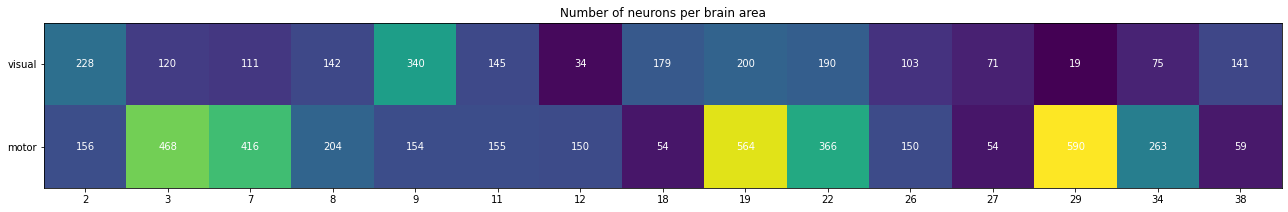

In [6]:
idx_session  = get_representative_sessions(1, 1)
# Get subset of selected sessions:
data = data[idx_session]

In [7]:
n_xval = 10
analysis_time_window = np.array([0,0.5]) # time window to analize
downsampling_factor = 'all'  # 'all'-> implies that the analisis time window is compressed to 1
trial_time = np.array([-0.5, 2])
samp_rate = 0.01


n_sessions = len(data)
exclude_pre = abs(analysis_time_window[0]-trial_time[0])
exclude_post = abs(analysis_time_window[1]-trial_time[1])
n_sessions = len(data)

In [8]:
print(len(data))

15


In [26]:
def visual_to_a1(n_set):
    # Get data
    visual_dat = utils.get_region_data(n_set, region='visual', data_type='fr')
    stim = n_set['stims']
    n_visual_neurons = visual_dat.shape[0]
    n_analysis_time_bins = visual_dat.shape[2]
    
    if n_analysis_time_bins==1:
        visual_dat = visual_dat.squeeze().T  # reshapes from neurons x trial x 1 bin, to trials x neurons
        # Model Linear Regression
        encoder, enc_coefs, enc_model = models.train_linear_encoder(stim, visual_dat)
        A1 = enc_coefs
        visual_dat_hat = encoder(stim)
    
        enc_perf = np.zeros((n_visual_neurons,n_xval))
        for neuron in range(n_visual_neurons):
            enc_perf[neuron] = cross_val_score(enc_model, stim, visual_dat[:,neuron], cv=n_xval, scoring='explained_variance')
        print(performance_per_neuron(visual_dat, visual_dat_hat, enc_perf))
    else:
        # need to implement a method for time window iteration
        raise NotImplementedError
    return A1

def performance_per_neuron(neurons, neurons_hat, enc_perf):
    #MSE and R2 per unit
    encoding_scores = pd.DataFrame(columns = ['r2', 'xval_r2', 'mse', 'nrmse'])
    encoding_scores['r2'] = metrics.r2(neurons.T,neurons_hat.T)
    encoding_scores['mse'] = metrics.mse(neurons.T,neurons_hat.T)
    encoding_scores['nrmse'] = metrics.nrmse(neurons.T,neurons_hat.T)
    encoding_scores['xval_r2'] = np.median(enc_perf,axis=1)

    return encoding_scores.mean()

In [27]:

data_set = [None] * n_sessions
 
for session in range(n_sessions):
    data_set[session] = utils.filter_no_go_choice(data[session])
    data_set[session]['fr'] = utils.spikes_to_fr(data_set[session]['spks'], 
                                    samp_rate=samp_rate, 
                                    downsampling_factor=downsampling_factor, 
                                    exclude_pre=exclude_pre, 
                                    exclude_post=exclude_post,
                                   )
    #print(f"fr shape {data_set[session]['fr'].shape}")
    #print(f"spks shape {data_set[session]['spks'].shape}")
    train_set, val_set = utils.split_validation_set(data_set[session])    
    visual_to_a1(train_set)


/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:18: RuntimeWarning: invalid value encountered in true_divide
  return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)
/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:64: RuntimeWarning: invalid value encountered in true_divide
  return rmse(y, y_hat) / np.mean(y, axis=1)


r2         0.064463
xval_r2    0.046813
mse        9.386191
nrmse      2.274047
dtype: float64
r2         0.036852
xval_r2   -0.011825
mse        6.452746
nrmse      1.681041
dtype: float64


/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:18: RuntimeWarning: invalid value encountered in true_divide
  return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)
/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:64: RuntimeWarning: invalid value encountered in true_divide
  return rmse(y, y_hat) / np.mean(y, axis=1)


r2         0.079580
xval_r2    0.097445
mse        2.609689
nrmse      1.588458
dtype: float64
r2         0.076324
xval_r2    0.060824
mse        3.920287
nrmse      1.612025
dtype: float64


/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:18: RuntimeWarning: invalid value encountered in true_divide
  return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)
/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:64: RuntimeWarning: invalid value encountered in true_divide
  return rmse(y, y_hat) / np.mean(y, axis=1)


r2         0.031003
xval_r2    0.029273
mse        3.053653
nrmse      2.245393
dtype: float64


/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:18: RuntimeWarning: invalid value encountered in true_divide
  return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)
/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:64: RuntimeWarning: invalid value encountered in true_divide
  return rmse(y, y_hat) / np.mean(y, axis=1)


r2         0.087580
xval_r2    0.084338
mse        7.080022
nrmse      2.011876
dtype: float64


/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:18: RuntimeWarning: invalid value encountered in true_divide
  return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)
/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:64: RuntimeWarning: invalid value encountered in true_divide
  return rmse(y, y_hat) / np.mean(y, axis=1)


r2         0.043659
xval_r2    0.072241
mse        5.035209
nrmse      1.958390
dtype: float64
r2         0.059919
xval_r2    0.029470
mse        5.689388
nrmse      1.409024
dtype: float64


/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:18: RuntimeWarning: invalid value encountered in true_divide
  return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)
/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:64: RuntimeWarning: invalid value encountered in true_divide
  return rmse(y, y_hat) / np.mean(y, axis=1)


r2         0.070175
xval_r2    0.051529
mse        4.584481
nrmse      2.154999
dtype: float64


/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:18: RuntimeWarning: invalid value encountered in true_divide
  return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)
/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:64: RuntimeWarning: invalid value encountered in true_divide
  return rmse(y, y_hat) / np.mean(y, axis=1)


r2         0.053122
xval_r2    0.048611
mse        6.412181
nrmse      1.597145
dtype: float64


/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:18: RuntimeWarning: invalid value encountered in true_divide
  return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)
/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:64: RuntimeWarning: invalid value encountered in true_divide
  return rmse(y, y_hat) / np.mean(y, axis=1)


r2          0.073243
xval_r2     0.067072
mse        18.443951
nrmse       2.238435
dtype: float64


/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:18: RuntimeWarning: invalid value encountered in true_divide
  return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)
/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:64: RuntimeWarning: invalid value encountered in true_divide
  return rmse(y, y_hat) / np.mean(y, axis=1)


r2         0.065281
xval_r2    0.045301
mse        6.157184
nrmse      1.967990
dtype: float64
r2         0.045906
xval_r2   -0.007790
mse        3.716899
nrmse      2.030196
dtype: float64
r2          0.047589
xval_r2     0.003692
mse        14.149680
nrmse       1.883129
dtype: float64
r2          0.039549
xval_r2     0.174552
mse        10.442746
nrmse       4.306226
dtype: float64


/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:18: RuntimeWarning: invalid value encountered in true_divide
  return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)
/Users/mgonzal1/Documents/WS/wombats-malos/wombats/metrics.py:64: RuntimeWarning: invalid value encountered in true_divide
  return rmse(y, y_hat) / np.mean(y, axis=1)
